In [1]:
import wpy as hp
import os
import pandas as pd

In [2]:
# parameters
model_name = 'W_CC_ONBOARDED_GAMERS_X'
cust_id_column_name = 'CUSTOMER_ID'
build_month = '202004'
modeller = 'Francis'
num_features_to_keep = 100

In [3]:
# TD cohort table for modelling
td_model_cohort_table = "c4ustpmk.CC_ONBOARDED_GAMERS_BASE"
# TD table containing socring population: cust id and data_dt
#td_score_population_name = "C4USTPMK.s_ccbt_x_score_population"
# feature table to be created for scoring
#td_score_table_name = "C4USTPMK.W_CC_GAMERS_X_score_population_features"
# sql script to create the above "td_score_table_name"
#score_sql_file_name = "scoring_population.sql"

In [5]:
cnxn = hp.connect_td(os.environ['TDPASS'])
query = 'sel * from {{COHORT_TABLE}}'.replace("{{COHORT_TABLE}}", td_model_cohort_table)
data = pd.read_sql(query, cnxn)
data = hp.col_upper_case(data)

target = hp.get_single_column(data, 'TARGET_F')

In [6]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
                     ('Var Dropper', hp.VarDropper()),
                     ('Imputer', hp.Imputer()),
                     ('Encoder', hp.Encoder())])

In [7]:
data.head()

,CUSTOMER_ID,DATA_DT,TARGET_F,PURCHA_TXN_AMT,PURCHA_TXN_QTY,PMBMMA_CC_NBUSN_FLAG,CBBMMI_CLI_CONSENT_FLAG,CCBMMA_BT_LAST_3_MONTHS,CCNHDL_CREDIT_LIMIT,CCNMSU_NUM_ACTIVE_ACCTS,...,PURMCC_FOODSTRWH_QTY,PURMCC_RSTAURBAR_AMT,PURMCC_RSTAURBAR_QTY,PURMCC_PETROLSTN_AMT,PURMCC_PETROLSTN_QTY,PURMCC_UTILITIES_AMT,PURMCC_UTILITIES_QTY,PURMCC_OTHRETAIL_QTY,PURMCC_DRUGSTORE_AMT,PURMCC_RCREATION_AMT
0,9.535262e+10,2018-06-30,1,0.0,0.0,0.0,2.0,0.0,15000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.207861e+10,2018-11-30,1,0.0,0.0,0.0,2.0,0.0,6000.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.430372e+10,2018-04-30,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.091080e+10,2018-09-30,0,NaN,NaN,0.0,0.0,0.0,7000.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.513532e+10,2018-10-31,0,NaN,NaN,0.0,1.0,0.0,4300.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# feature reduction
df = pipeline.transform(data)

In [9]:
from sklearn.model_selection import train_test_split
features = df.columns
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3)

In [10]:
import xgboost as xgb
model = xgb.XGBClassifier().fit(X_train, y_train)

In [11]:
top_features = hp.get_var_importance(model, features, num_features_to_keep)

In [12]:
dfx = pipeline.transform(data[list(top_features.index)])
# features_final = dfx.columns
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(dfx, target, test_size=0.3)

In [13]:
model_final = xgb.XGBClassifier().fit(X_train, y_train)
model_final.fit(X_train_final, y_train_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [14]:
probas = model_final.predict_proba(X_test_final)
hp.print_model_performance(model_final, X_test_final, y_test_final)

Accuracy: 0.775000
Confustion Matrix: 
[[1745  244]
 [ 431  580]]
AUC Score: 0.831766
GINI Coefficient: 0.663532


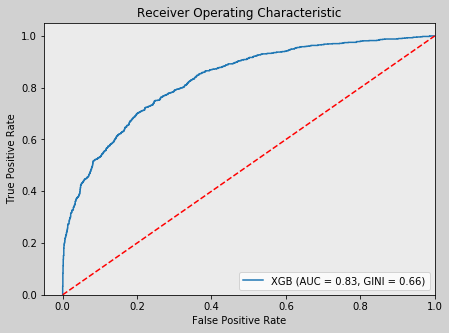

In [15]:
hp.plot_roc(model=model_final, model_label='XGB', X_test=X_test_final, y_test=y_test_final)

In [16]:
top_features

,importance
PMBMMA_CC_NBUSN_FLAG,0.041667
CUNQSL_EQUITY_COST,0.041667
CREDIT_LIMIT,0.041667
LOYALTY_PROGRAM_IND,0.041667
CLOSED_ACCOUNTS,0.037202
TWNMZZ_CUST_INCOME_TURNOVER,0.034226
CCNHDL_CREDIT_LIMIT,0.032738
MYNHSL_AVG_TRANS_VALUES,0.031250
PURCHA_TXN_AMT,0.028274
TRNHMI_CREDIT_CARD_MIN,0.028274
